In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import catboost as catb

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

**Обзор данных**

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Загрузка данных**

In [425]:
TRAIN_DATASET_PATH = '/Users/OzzyPeople/documents/GeekBrains/0_MLClassification/data/course_project_train.csv'
TEST_DATASET_PATH = '/Users/OzzyPeople/documents/GeekBrains/0_MLClassification/data/course_project_test.csv'

In [426]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


In [436]:
df_train.shape

(7500, 17)

In [437]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                       5.91983
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [438]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [439]:
df_test.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [440]:
df_test.shape

(2500, 16)

**Обзор целевой переменной**

In [441]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

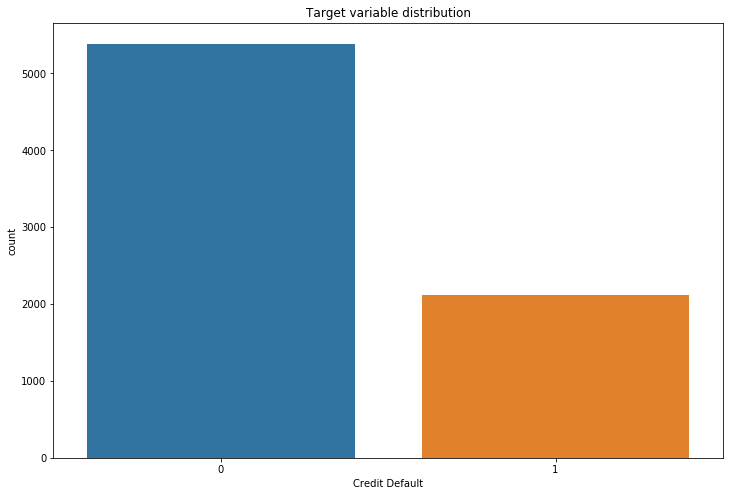

In [442]:
plt.figure(figsize=(12, 8))
sns.countplot(x=df_train['Credit Default'], data=df_train)
plt.title('Target variable distribution')
plt.show()

**Обзор количественных признаков**

In [443]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,5.919834,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,3.468794,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.500000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [444]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7500 non-null float64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  

**Обзор номинативных признаков**

In [445]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************************************************************************

Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64
****************************************************************************************************



### Обработка пропусков<a class="anchor" id="gaps"></a>

In [446]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [447]:
mean_value_income=df_train['Annual Income'].mean()
df_train['Annual Income']=df_train['Annual Income'].fillna(mean_value_income)

In [448]:
mean_value_months = df_train['Months since last delinquent'].mean()
df_train['Months since last delinquent']=df_train['Months since last delinquent'].fillna(mean_value_months)

In [449]:
mean_value_credit = df_train['Credit Score'].mean()
df_train['Credit Score']=df_train['Credit Score'].fillna(mean_value_credit)

In [450]:
#Заполним недостающие значения mode 
bankruptcies_mode = df_train['Bankruptcies'].mode()
df_train['Bankruptcies']=df_train['Bankruptcies'].fillna(bankruptcies_mean)

In [431]:
vals_to_replace = {'< 1 year' : 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, \
                  '7 years' : 7, '8 years' : 8, '9 years' : 9 , '10+ years' : 10}  

In [432]:
df_train['Years in current job'] = df_train['Years in current job'].map(vals_to_replace)

In [435]:
df_train['Years in current job']=df_train['Years in current job'].fillna(df_train['Years in current job'].mean())

In [ ]:
df_train.isnull().sum()

**Обработка выбросов**

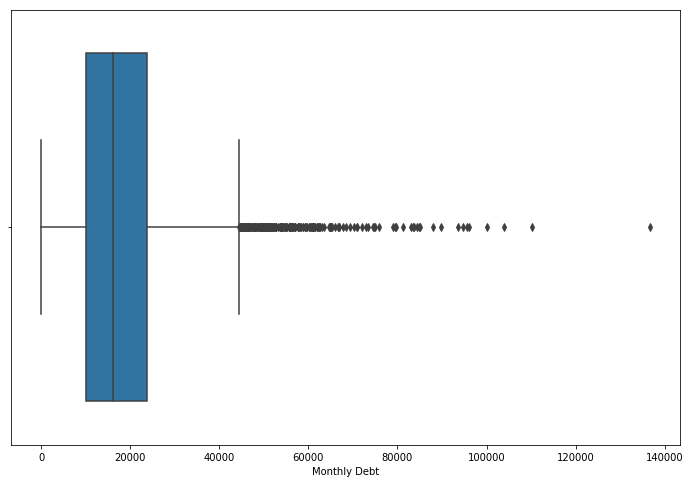

In [451]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=df_train['Monthly Debt'])

In [452]:
#Оценка отношения количества выбросов к общему количеству признака

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    num = (len(df_in)- len(df_out))/len(df_in)
    return num

Оценим выбросы по некатегориильным признакам, разбив признаки на категориальные и вещественные (непрерывные) 

In [453]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term', 'Tax Liens', \
                      'Bankruptcies']

In [454]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Years of Credit History', 'Number of Open Accounts',\
       'Maximum Open Credit','Months since last delinquent', 'Number of Credit Problems', \
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

In [455]:
SELECTED_FEATURE_NAMES = CAT_FEATURE_NAMES + NUM_FEATURE_NAMES

In [456]:
TARGET_NAME = 'Credit Default'

In [457]:
for i in NUM_FEATURE_NAMES:
    print (f'% выбросов признака {i} = {remove_outlier(df_train, i)*100}')

% выбросов признака Annual Income = 6.88
% выбросов признака Years in current job = 0.0
% выбросов признака Years of Credit History = 3.04
% выбросов признака Number of Open Accounts = 3.0533333333333332
% выбросов признака Maximum Open Credit = 6.213333333333333
% выбросов признака Months since last delinquent = 100.0
% выбросов признака Number of Credit Problems = 100.0
% выбросов признака Current Loan Amount = 11.600000000000001
% выбросов признака Current Credit Balance = 5.866666666666666
% выбросов признака Monthly Debt = 3.4000000000000004
% выбросов признака Credit Score = 5.333333333333334


Пока ничего не будем менять, как вариант, стоит категоризировать признак Months since last delinquent

Переводим в бинарные величины категориальный признаки

In [458]:
df = pd.get_dummies(df_train, columns = CAT_FEATURE_NAMES)

**Нормализация данных**

In [459]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [460]:
X = df.drop([TARGET_NAME], axis = 1)
y = df[TARGET_NAME]

In [461]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [462]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    #количество повторов минорного класса, которые необходимо сделать, чтобы сбалансировать обучение модели - вбыорку 
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [463]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing[TARGET_NAME].value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [464]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [465]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [466]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

In [467]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Логистическая регрессия**

In [468]:
%%time
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.84      0.76      3771
           1       0.72      0.50      0.59      2958

   micro avg       0.69      0.69      0.69      6729
   macro avg       0.70      0.67      0.67      6729
weighted avg       0.70      0.69      0.68      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.53      0.50      0.51       634

   micro avg       0.74      0.74      0.74      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1341  275
1                320  314
CPU times: user 170 ms, sys: 36.7 ms, total: 207 ms
Wall time: 202 ms


**k ближайших соседей**

In [469]:
%%time
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      3771
           1       0.79      0.71      0.75      2958

   micro avg       0.79      0.79      0.79      6729
   macro avg       0.79      0.78      0.78      6729
weighted avg       0.79      0.79      0.79      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1616
           1       0.44      0.49      0.46       634

   micro avg       0.68      0.68      0.68      2250
   macro avg       0.62      0.62      0.62      2250
weighted avg       0.69      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1227  389
1                326  308
CPU times: user 4.5 s, sys: 50.5 ms, total: 4.55 s
Wall time: 4.66 s


**Бустинговые алгоритмы**

In [470]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      3771
           1       0.79      0.58      0.67      2958

   micro avg       0.75      0.75      0.75      6729
   macro avg       0.76      0.73      0.73      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.49      0.52       634

   micro avg       0.75      0.75      0.75      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1370  246
1                324  310
CPU times: user 2.02 s, sys: 34 ms, total: 2.05 s
Wall time: 1.87 s


In [471]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

NameError: name 'lgbm' is not defined

In [472]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      3771
           1       0.96      0.89      0.92      2958

   micro avg       0.93      0.93      0.93      6729
   macro avg       0.94      0.93      0.93      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1616
           1       0.57      0.47      0.52       634

   micro avg       0.75      0.75      0.75      2250
   macro avg       0.69      0.67      0.68      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1393  223
1                334  300
CPU times: user 14.6 s, sys: 1.34 s, total: 15.9 s
Wall time: 6.93 s
